In [1]:
import sys
sys.path.append('../')
import networkx as nx
from smodels.theory.auxiliaryFunctions import getTreeRoot, elementsInStr, _flattenList
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from smodels.theory.element import Element
from smodels.theory.branch import InclusiveBranch
from smodels.experiment.finalStateParticles import finalStates

from string import ascii_uppercase

In [2]:
def stringToTree(info,finalState=None):
    """
    Creates a Tree (DiGraph object) object from a string in bracket notation.
    
    :parameter info: string describing the element in bracket notation
                     (e.g. [[[e+],[jet]],[[e-],[jet]]])
                     
    :parameter finalState: list containing the final state labels for each branch
                     (e.g. ['MET', 'HSCP'] or ['MET','MET']). If not defined it will
                     be assumed to be MET for all branches
    :return: Tree (nerworkX DiGraph object)
                         
    """


    elements = elementsInStr(info,removeQuotes=False)
    if not elements or len(elements) > 1:
        nel = 0
        if elements:
            nel = len(elements)
        logger.error("Malformed input string. Number of elements "
                      "is %d (expected 1) in: ``%s''", nel, info)
        raise SModelSError()
    
    branches = eval(elements[0].replace('[*]',"['InclusiveBranch']"))
    if not branches:
        logger.error("Malformed input string. Number of "
                      "branches is %d (expected 2) in: ``%s''",
                      len(branches), info)
        raise SModelSError()

    if finalState:
        if not isinstance(finalState,list) or len(finalState) != len(branches):
            logger.error("Number of final states (%i) does not match number of branches (%i)" 
                               %(len(finalState),len(branches)))
            raise SModelSError()
    else:
        finalState = ['MET']*len(branches)

    #Create map with all required particle objects for building the graph:
    fstateDict = {'anyOdd' : finalStates.getParticlesWith(label='anyOdd')[0],
                  'PV' : finalStates.getParticlesWith(label='PV')[0],
                 'InclusiveBranch' : InclusiveBranch()}
    #Add final state to the end of each branch:    
    for ib,branch in enumerate(branches):
        if not branch:
            branches[ib] = finalState[ib]  #The PV decays directly to the final state
        else:
            branch.append(finalState[ib])
    for ptc in _flattenList(branches) + finalState:
        if not ptc in fstateDict:
            particle = finalStates.getParticlesWith(label=ptc)
            if not particle or len(particle) != 1:
                logger.error("Error retrieving particle %s from finalStateParticles. Is this particle uniquely defined?")
                raise SModelSError()
            particle = particle[0]
            fstateDict[ptc] = particle

    #Create element rooted tree (starting with primary vertex = zero node):
    tree = vertexListToTree(branches,particleDict=fstateDict,parentNode=0,parentParticle=fstateDict['PV'])

    return tree


def branchListToTree(bList,particleDict,parentNode,parentParticle):
    """
    Creates a Tree (DiGraph object) from a nested list.
    The list should correspond to a series of sequential decays
    of 'anyOdd' particles (e.g.  [[a,b],[c]] =  X -> a+b+Y, Y->c) 
    If one of the entries of the list is a string, it is assumed
    to correspond to a final state to the previous odd particle
    (e.g. [[a,b],[c],MET] =  X -> a+b+Y, Y->c+MET, [[a,b],MET,[c]] =  X -> a+b+Y+MET, Y->c).
    A branch with a single particle should be represented by [X]
    (e.g. [HSCP] -> PV->HSCP).
    
    :parameter bList: List object containing a list of vertices or vertices and particles
                     (e.g. [[e+],[jet]],[[e+],[jet],MET])
    :parameter particleDict: Dictionary used to map strings to Particle objects.
    :parameter parentNode: Name of the parent node (integer). First node in the sequential decay
    :parameter parentParticle: Particle object corresponding to the first particle in the sequential decay.
                     
                     
    :return: Tree (nerworkX DiGraph object)
                         
    """    
    
    if not isinstance(bList,list):
        logger.error("Malformed bracket expression. Expecting a list and received %s" %str(bList))
        raise SModelSError()

    #Create tree
    T = nx.DiGraph()
    #The first entry in bList should correspond to the parent decay
    node = parentNode
    momNode = parentNode
    #Create a sequential Tree (each entry in bList is added in a sequence of levels)
    for vList in bList:        
        if isinstance(vList,list): #entry correspond to a vertex:
            #Each entry corresponding to an odd-particle in the vertex
            T.add_node(node,particle=particleDict['anyOdd'])
            if node != parentNode:
                T.add_edge(momNode,node)
            vTree = vertexListToTree(vList,particleDict,parentNode=node,
                                     parentParticle=T.nodes[node]['particle'])
            T = nx.compose(T,vTree)
            momNode = node
        elif isinstance(vList,str):  #entry correspond to an odd particle (e.g. a Z2-odd final state)
            if not vList in particleDict:
                logger.error("Particle %s not found in dictionary" %vList)
                raise SModelSError()
            ptc = particleDict[vList]
            T.add_node(node,particle=ptc)
            if node != parentNode:
                T.add_edge(momNode,node)            
            T.add_edge(momNode,node)            
        #Every sequential node added corresponds to going one level down the tree
        #Add digit everytime you go down one level:
        node *= 10
    return T
        

def vertexListToTree(vList,particleDict,parentNode,parentParticle):
    """
    Creates a Tree (DiGraph object) from a list.
    The list should correspond to a vertex (list of daughters from the same parent)
    (e.g.  [a,b] =  parentParticle -> a+b) .
    If one of the entries of the list is another list, it is assumed to correspond
    to a new (nested) branch (e.g. [ [[a,b]] , c ] -> parent -> X(->a+b) + c)
    
    :parameter vList: List object containing a list of daughters belonging to the same decay vertex
                     (e.g. [e+,jet,MET])
    :parameter particleDict: Dictionary used to map strings to Particle objects.
    :parameter parentNode: Name of a parent node (integer)
    :parameter parentParticle: Particle object corresponding to the parent of the vertex
                     
    :return: Tree (nerworkX DiGraph object)
                         
    """        
    
    if not isinstance(vList,list):
        logger.error("Malformed bracket expression. Expecting a list and received %s" %str(vList))
        raise SModelSError()
                     
                     
    #Create tree
    T = nx.DiGraph()
    #Always include the parent node in the graph:
    momNode = parentNode
    T.add_node(parentNode,particle=parentParticle)
    #A vertex is always one level below the parent. Add digit everytime you go down one level:
    node = 10*parentNode
    #Create a parallel Tree (each entry in vList is added at the same level/same parent)
    for p in vList:
        node += 1 # Add unit everytime you add a sibling (node at the same tree level)
        if isinstance(p,str):  #Entry in vertex is a Z2-even particle
            if not p in particleDict:
                logger.error("Particle %s not found in dictionary" %p)
                raise SModelSError()
            ptc = particleDict[p]
            T.add_node(node,particle=ptc)
            T.add_edge(momNode,node)
        elif isinstance(p,list): #Entry in vertex is another branch
            T.add_node(node,particle=particleDict['anyOdd'])
            T.add_edge(momNode,node)            
            branchTree = branchListToTree(p,particleDict,parentNode=node,
                                          parentParticle=T.nodes[node]['particle'])
            T = nx.compose(T,branchTree)
    return T

In [13]:
elementStr = "[[*],[['mu-'],['nu','nu']]]"
g = stringToTree(elementStr)
el = Element(info=g)
el.drawTree(nodeScale=2)

RecursionError: maximum recursion depth exceeded

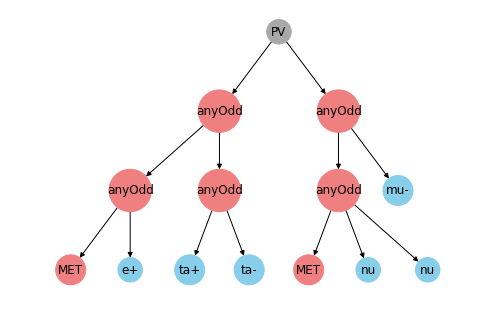

In [59]:
import matplotlib.pyplot as plt

labels = dict([[n,g.nodes[n]['particle'].label] 
               for n in g.nodes()])
oddColor = 'lightcoral'
evenColor = 'skyblue'
pvColor = 'darkgray'
nodeScale = 4
node_size = []
node_color = []
for n in g.nodes():
    node_size.append(3*100*len(labels[n]))
    if 'pv' == labels[n].lower():
        node_color.append(pvColor)
    elif g.nodes[n]['particle'].Z2parity == 'odd':
        node_color.append(oddColor)
    else:
        node_color.append(evenColor)
pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot')
nx.draw(g,pos,
        with_labels=True,
        arrows=True,
        labels=labels,
        node_size=node_size,
        node_color=node_color)



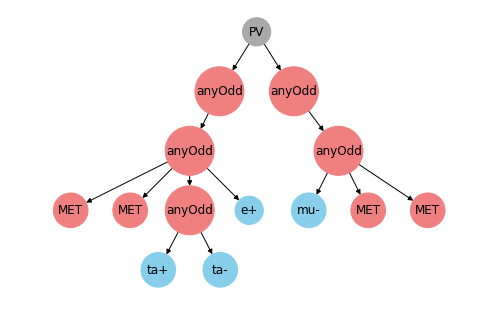

In [17]:
elementStr = "[[[['ta+','ta-'],'e+']],[['mu-']]]"
g = stringToGraph(elementStr)
el = Element(info=g)
el.drawTree()

In [16]:
eval("[[*],[['*'],[ '*']]]".replace('[*]',"'InclusiveBranch'"))

['InclusiveBranch', [['*'], ['*']]]